In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from tomopt.muon import *
from tomopt.inference import *
from tomopt.volume import *
from tomopt.core import *
from tomopt.optimisation import *

import matplotlib.pyplot as plt
import seaborn as sns
from typing import *
import numpy as np

import torch
from torch import Tensor, nn
import torch.nn.functional as F

# Basics

In [3]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

In [4]:
def eff_cost(x:Tensor) -> Tensor:
    return torch.expm1(3*F.relu(x))

In [5]:
def res_cost(x:Tensor) -> Tensor:
    return F.relu(x/100)**2

In [6]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    pos = 'above'
    for z,d in zip(np.arange(lwh[2],0,-size), [1,1,0,0,0,0,0,0,1,1]):
        if d:
            layers.append(DetectorLayer(pos=pos, init_eff=init_eff, init_res=init_res,
                                        lw=lwh[:2], z=z, size=size, eff_cost_func=eff_cost, res_cost_func=res_cost))
        else:
            pos = 'below'
            layers.append(PassiveLayer(rad_length_func=arb_rad_length, lw=lwh[:2], z=z, size=size))

    return nn.ModuleList(layers) 

In [7]:
volume = Volume(get_layers())

# VolumeWrapper

In [8]:
from functools import partial

In [18]:
volume = Volume(get_layers())

In [19]:
wrapper = VolumeWrapper(volume=volume, res_opt=partial(torch.optim.SGD, lr=2e10), eff_opt=partial(torch.optim.SGD, lr=2e5),
                        loss_func=DetectorLoss(0))

In [20]:
from tomopt.optimisation import MetricLogger

In [21]:
ml = MetricLogger(show_plots=True)

In [22]:
trn_passives = PassiveYielder([arb_rad_length])

In [23]:
from tomopt.optimisation.callbacks.callback import Callback

In [24]:
class ParamCap(Callback):
    def on_volume_batch_begin(self) -> None:
        with torch.no_grad():
            for d in self.wrapper.volume.get_detectors():
                torch.clamp_(d.resolution, min=1, max=1e7)
                torch.clamp_(d.efficiency, min=1e-7, max=1)

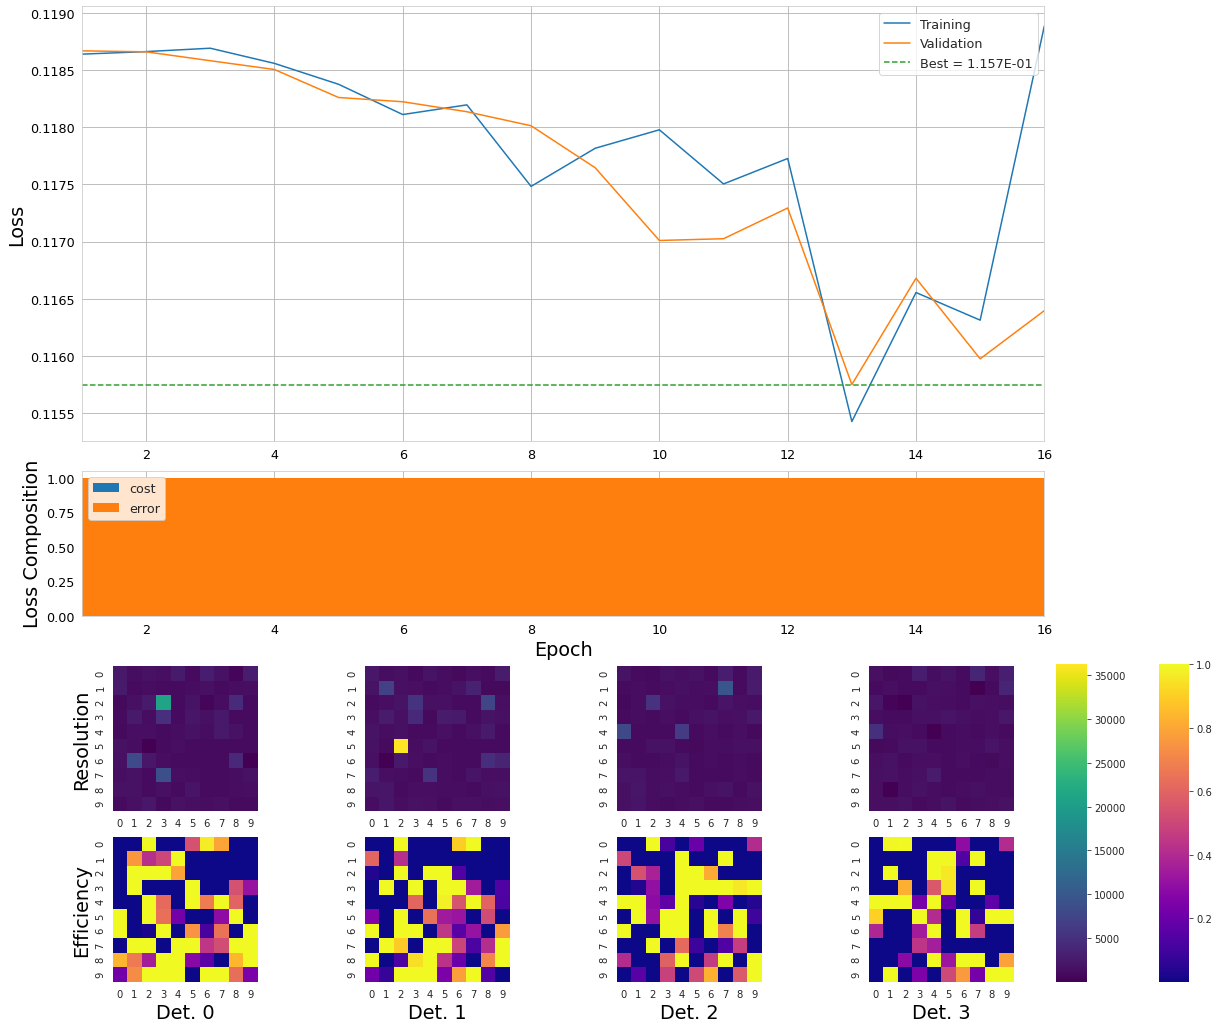

/Users/giles/cernbox/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:203: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


KeyboardInterrupt: 

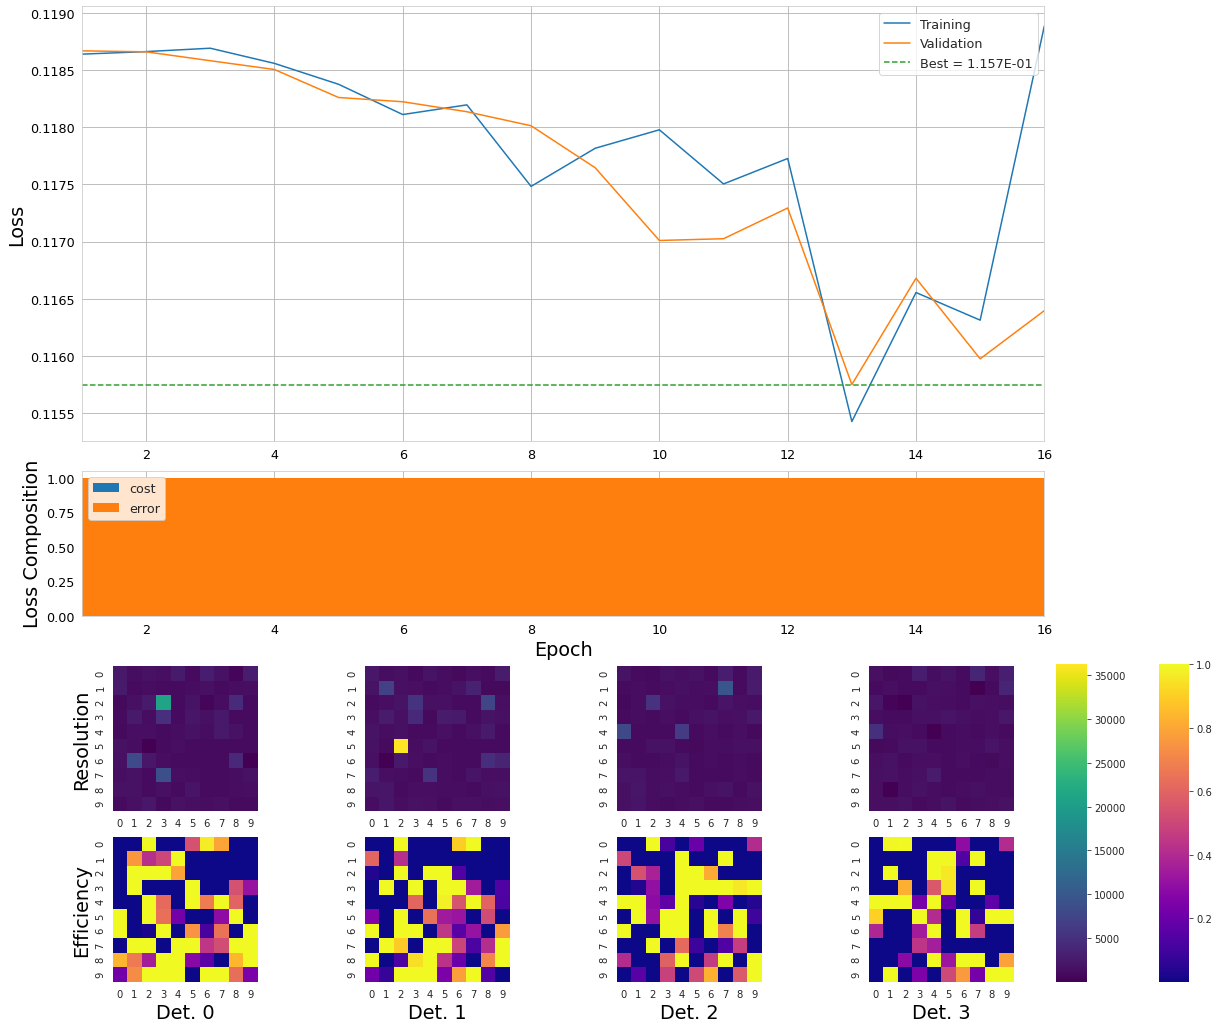

In [25]:
%%time
_ = wrapper.fit(25, n_mu_per_volume=1000, mu_bs=100, passive_bs=1, trn_passives=trn_passives, val_passives=trn_passives, cbs=[NoMoreNaNs(),ParamCap(),ml])

In [17]:
for d in volume.get_detectors():
    print(1, d.resolution, d.efficiency)

1 Parameter containing:
tensor([[1000.0127, 1000.4893,  999.9008,  999.9188, 1000.4068, 1000.0093,
         1000.1916, 1000.0230,  961.0676, 1000.4098],
        [1000.2267, 1000.1845, 1000.2405, 1000.1183,  999.8533,  999.8566,
         1000.2650, 1000.2728, 1000.0188,  997.7445],
        [1003.1630, 1000.1562, 1000.0332, 1000.2754, 1000.0543, 1000.2820,
         1000.1427,  999.7401,  999.8630, 1000.1888],
        [1000.7008, 1000.0506, 1000.1895, 1000.1197, 1000.9570,  999.9113,
         1000.2156, 1000.1126, 1000.4127, 1000.4337],
        [ 999.4669, 1000.1302, 1000.1102,  999.9175,  999.9287, 1000.1906,
         1000.2624, 1000.1174,  999.9720, 1000.1603],
        [1000.0530, 1000.0786, 1000.1669, 1000.2338, 1000.0674,  999.9667,
         1000.0270, 1000.2304, 1000.0071,  999.8253],
        [1000.2546, 1000.3882, 1000.1860,  999.7719, 1000.0918, 1000.0026,
          999.9720,  999.9946,  999.9108,  999.8855],
        [ 998.9213,  999.8340, 1000.0056, 1000.0243,  999.9039, 1000.0316